In [457]:
import requests
import json
from bs4 import BeautifulSoup
import pandas as pd
from urllib.parse import urlparse
import re
import numpy as np



In [458]:
## CREATE THE EVENTS DATABASE AND THEN THE LIST WITH THE URLS

In [459]:
url_events = "https://api.fiteq.org/v1/event"

In [460]:
r_events = requests.get(url_events)

In [461]:
soup_events = BeautifulSoup(r_events.content, 'html.parser')

In [462]:
data_events = json.loads(soup_events.text)

In [463]:
df_events = pd.DataFrame.from_dict(data_events['past'])


In [464]:
events_list = df_events['id'].to_list()

In [465]:
events_name = df_events['name'].to_list()

In [466]:
## Build URLs for each tournament

In [467]:
url_base = 'https://api.fiteq.org/v1/event/matches/'

In [468]:
urltexts = []

for url in events_list:
    urltexts.append(url_base + str(url))
    
print(urltexts[0:5])

['https://api.fiteq.org/v1/event/matches/4', 'https://api.fiteq.org/v1/event/matches/14', 'https://api.fiteq.org/v1/event/matches/15', 'https://api.fiteq.org/v1/event/matches/19', 'https://api.fiteq.org/v1/event/matches/20']


In [469]:
urls = []
for text in urltexts:
    urls.append(urlparse(text).geturl())


In [470]:
urls

['https://api.fiteq.org/v1/event/matches/4',
 'https://api.fiteq.org/v1/event/matches/14',
 'https://api.fiteq.org/v1/event/matches/15',
 'https://api.fiteq.org/v1/event/matches/19',
 'https://api.fiteq.org/v1/event/matches/20',
 'https://api.fiteq.org/v1/event/matches/21',
 'https://api.fiteq.org/v1/event/matches/22',
 'https://api.fiteq.org/v1/event/matches/24',
 'https://api.fiteq.org/v1/event/matches/25',
 'https://api.fiteq.org/v1/event/matches/26',
 'https://api.fiteq.org/v1/event/matches/27',
 'https://api.fiteq.org/v1/event/matches/28',
 'https://api.fiteq.org/v1/event/matches/29',
 'https://api.fiteq.org/v1/event/matches/31',
 'https://api.fiteq.org/v1/event/matches/32',
 'https://api.fiteq.org/v1/event/matches/33',
 'https://api.fiteq.org/v1/event/matches/35',
 'https://api.fiteq.org/v1/event/matches/37',
 'https://api.fiteq.org/v1/event/matches/38',
 'https://api.fiteq.org/v1/event/matches/41',
 'https://api.fiteq.org/v1/event/matches/55',
 'https://api.fiteq.org/v1/event/ma

In [471]:
## NOW WE HAVE THE URLS for all competitions. Read in now all databases from the API

In [472]:
df = pd.DataFrame()

In [473]:
for url, event_name in zip(urls, events_name):
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    data = json.loads(soup.text)
    dataframe = pd.DataFrame(data['results'])
    dataframe['event_name'] = str(event_name)

    
    df = df.append(dataframe)



<ipython-input-473-a4ea6bd33731>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dataframe)
<ipython-input-473-a4ea6bd33731>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dataframe)
<ipython-input-473-a4ea6bd33731>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dataframe)
<ipython-input-473-a4ea6bd33731>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dataframe)
<ipython-input-473-a4ea6bd33731>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dataframe)
<ipython-input-

In [474]:
df1 = df[['event_name', 'type', 'playerAName', 'associationPlayer_A', 'playerBName', 'associationPlayer_B', 'playerXName', 'associationPlayer_X', 'playerYName', 'associationPlayer_Y', 'stage', 'scoreSets', 'matchDateTime', 'setsWon_A', 'setsWon_X', 'pointTotal_A', 'pointTotal_X']]

In [475]:
scores_list =[]
df1 = df1[(df1['pointTotal_A'] + df1['pointTotal_X']) != 0].reset_index(drop=True)
df1 = df1[df1.scoreSets.str.len() != 0].reset_index(drop=True)

set1_AB = []
set1_XY = []

set2_AB = []
set2_XY = []

set3_AB = []
set3_XY = []

In [476]:

for i in range(len(df1['scoreSets'])):
    if len(df1.scoreSets[i]) == 3:
        set1_AB.append(df1.scoreSets[i][0]['a'])
        set1_XY.append(df1.scoreSets[i][0]['x'])

        set2_AB.append(df1.scoreSets[i][1]['a'])
        set2_XY.append(df1.scoreSets[i][1]['x'])

        set3_AB.append(df1.scoreSets[i][2]['a'])
        set3_XY.append(df1.scoreSets[i][2]['x'])

    elif len(df1.scoreSets[i]) == 2:
        set1_AB.append(df1.scoreSets[i][0]['a'])
        set1_XY.append(df1.scoreSets[i][0]['x'])

        set2_AB.append(df1.scoreSets[i][1]['a'])
        set2_XY.append(df1.scoreSets[i][1]['x'])

        set3_AB.append(0)
        set3_XY.append(0)

    else:
        set1_AB.append(df1.scoreSets[i][0]['a'])
        set1_XY.append(df1.scoreSets[i][0]['x'])
        
        set2_AB.append(0)
        set2_XY.append(0)

        set3_AB.append(0)
        set3_XY.append(0);

In [477]:
len(set1_AB) == len(set1_XY) == len(set2_AB) == len(set2_XY) == len(set3_AB) == len(set3_XY)

True

In [478]:
## Columns we need:
 ## Event Name, Category, Player A, Association Player A, Player B, Association Player B, Player X, Association Player X, Player Y, Association Player Y, 
 # Stage, Set 1 AB, Set 1 XY, Set 2 AB, Set 2 XY, Set 3 AB, Set 3 XY, Match Date, Sets Won AB, Sets Won XY, Points total AB, Points total XY, Winner, Loser

In [479]:
df1['playerAName'] = df1['playerAName'].apply(lambda x: x.title())
df1['playerBName'] = df1['playerBName'].apply(lambda x: x.title())
df1['playerXName'] = df1['playerXName'].apply(lambda x: x.title())
df1['playerYName'] = df1['playerYName'].apply(lambda x: x.title())

In [480]:
## Add scores to columns
df1['set1_AB'] = set1_AB
df1['set1_XY'] = set1_XY
df1['set2_AB'] = set2_AB
df1['set2_XY'] = set2_XY
df1['set3_AB'] = set3_AB
df1['set3_XY'] = set3_XY
df1.drop('scoreSets', axis = 1, inplace = True)


In [481]:
df1.replace(np.nan, "", inplace = True )
df1.replace("NaN", "", inplace = True)
df1['setsWon_A'] = df1['setsWon_A'].apply(lambda x: int(float(x)))
df1['setsWon_X'] = df1['setsWon_X'].apply(lambda x: int(float(x)))
df1['pointTotal_A'] = df1['pointTotal_A'].apply(lambda x: int(float(x)))
df1['pointTotal_X'] = df1['pointTotal_X'].apply(lambda x: int(float(x)))


In [482]:
df1['set2_AB'].replace('', 0, inplace = True)
df1['set2_XY'].replace('', 0, inplace = True)
df1['set3_AB'].replace('', 0, inplace = True)
df1['set3_XY'].replace('', 0, inplace = True)


In [483]:
df1['set2_AB']= df1['set2_AB'].apply(lambda x: int(float(x)))
df1['set2_XY']= df1['set2_XY'].apply(lambda x: int(float(x)))
df1['set3_AB']= df1['set3_AB'].apply(lambda x: int(float(x)))
df1['set3_XY']= df1['set3_XY'].apply(lambda x: int(float(x)))

In [484]:
df1.loc[:, 'playerAName': 'playerYName'].replace(np.nan, "", inplace = True)

In [485]:
df1.tail()

,event_name,type,playerAName,associationPlayer_A,playerBName,associationPlayer_B,playerXName,associationPlayer_X,playerYName,associationPlayer_Y,...,setsWon_A,setsWon_X,pointTotal_A,pointTotal_X,set1_AB,set1_XY,set2_AB,set2_XY,set3_AB,set3_XY
11082,Brazilian Teqball Tour - Porto Alegre,DoublesMen,Alexandre Dos Santos Garcia Filho,Brazil,Pedro Henrique Santos Araujo,Brazil,Leonardo Lindoso De Almeida,Brazil,Joao Pedro Nunes Sonda,Brazil,...,0,2,8,24,0,12,8,12,0,0
11083,Brazilian Teqball Tour - Porto Alegre,DoublesMen,Matheus Ferraz,Brazil,Rodrigo Bento Medeiros,Brazil,Carlos Vasques,Brazil,Marcos Vieira,Brazil,...,2,0,24,12,12,5,12,7,0,0
11084,Brazilian Teqball Tour - Porto Alegre,DoublesMen,Luiz Fernando De Mendonca De Lima,Brazil,Claudio Davi Ponte Dos Santos,Brazil,Leonardo Lindoso De Almeida,Brazil,Joao Pedro Nunes Sonda,Brazil,...,2,1,31,31,12,9,7,12,12,10
11085,Brazilian Teqball Tour - Porto Alegre,DoublesMen,Carlos Vasques,Brazil,Marcos Vieira,Brazil,Leonardo Lindoso De Almeida,Brazil,Joao Pedro Nunes Sonda,Brazil,...,0,2,14,24,8,12,6,12,0,0
11086,Brazilian Teqball Tour - Porto Alegre,DoublesMen,Matheus Ferraz,Brazil,Rodrigo Bento Medeiros,Brazil,Luiz Fernando De Mendonca De Lima,Brazil,Claudio Davi Ponte Dos Santos,Brazil,...,1,2,26,30,12,6,5,12,9,12


In [486]:
idx = (df1['playerAName'] > df1['playerBName']) & (df1['playerBName'] != "")
idy = (df1['playerXName'] > df1['playerYName']) & (df1['playerYName'] != "")

In [487]:
df1.loc[idx,['playerAName', 'associationPlayer_A','playerBName', 'associationPlayer_B']] = df1.loc[idx,['playerBName', 'associationPlayer_B','playerAName', 'associationPlayer_A']].values
df1.loc[idy,['playerXName', 'associationPlayer_X','playerYName', 'associationPlayer_Y']] = df1.loc[idy,['playerYName', 'associationPlayer_Y','playerXName', 'associationPlayer_X']].values

In [488]:
"Z" > 'Adam Blazsovics'

True

In [489]:
df1.sample(15)

,event_name,type,playerAName,associationPlayer_A,playerBName,associationPlayer_B,playerXName,associationPlayer_X,playerYName,associationPlayer_Y,...,setsWon_A,setsWon_X,pointTotal_A,pointTotal_X,set1_AB,set1_XY,set2_AB,set2_XY,set3_AB,set3_XY
10754,Teqball World Series - Paris,DoublesMen,Baptiste Berna,Portugal,Loris Kapp,France,Anas Beg,India,Vinit Jain,India,...,2,0,24,16,12,5,12,11,0,0
4804,India Challenger Series - Round 2,DoublesMen,Gnana Prabhu Rajendran,India,J Naveen Bhrath Iyyappan,India,Sabari Manikandan Raguraman,India,Sivakumar Kasi,India,...,2,0,24,16,12,7,12,9,0,0
4866,India Challenger Series - Round 2,DoublesMixed,Jagadeep Murugan,India,Vaishnavi D Dharmaraj,India,Jebin Mersarin Clarat,India,Kavi Priya Parthasarathi,India,...,2,0,24,17,12,8,12,9,0,0
4518,Ivory Coast Challenger Series - Round 4,SinglesFree,Obed Ngoran,Ivory Coast,,,Fidel Koffi,Ivory Coast,,,...,1,2,23,31,12,7,6,12,5,12
313,Budapest Challenger Cup 2019,SinglesFree,Julien Grondin,France,,Alabama,Gabor Fabian,Hungary,,Alabama,...,1,0,20,16,20,16,0,0,0,0
8552,Nigeria Challenger Series - Round 3,SinglesFree,Ifeanyi Cornelius Ezeigbo,Nigeria,,,Haladu Mubarak,Nigeria,,,...,0,2,5,24,2,12,3,12,0,0
7877,Creil Challenger Cup,SinglesFree,Szabolcs Ilyes,Romania,,,Hubert Sylvain Noah Essomba,Cameroon,,,...,2,0,24,11,12,7,12,4,0,0
5828,Zabki Challenger Cup,SinglesMen,Marek Pokwap,Poland,,,Adam Blazsovics,Hungary,,,...,1,2,17,32,12,8,2,12,3,12
5559,Bulgaria Challenger Series - Round 4,SinglesFree,Aleksandar Zaykov,Bulgaria,,,Angelina Atanasova,Bulgaria,,,...,2,0,24,4,12,3,12,1,0,0
1398,Teqball World Championships 2018,SinglesFree,Omri Cohen,Israel,,,Martijn Ten Duis,Netherlands,,,...,0,1,3,20,3,20,0,0,0,0


In [490]:
df1 = df1[df1['event_name'].apply(lambda x: x not in ['III. Warsaw Challenger Cup 2019', 'Novi Sad Challenger Cup 2019', 'II. Warsaw Challenger Cup 2019', 'Teqball Masters 2019', 'Budapest Challenger Cup 2019', 'Balassagyarmat Challenger Cup 2019', 'Asia-Pacific Beach Teqball Cup', 'African Beach Teqball Cup', 'Teqball World Championships 2019 '
, 'II. Balassagyarmat Challenger Cup 2019', 'Xiamen Challenger Cup 2020', 'Dunaújváros Challenger Cup 2020', 'Budapest Women Challenger Cup 2020', 'Teqball World Championships 2018', 'Warsaw Cup 2019','Chocen Challenger Cup 2020'])]

In [491]:
df1.reset_index(drop = True, inplace = True )

In [492]:
df1 = df1[df1['set1_AB'] <= 12]

In [493]:
df1.to_csv('dataframe.csv', index= False)

In [494]:
df1.head()

,event_name,type,playerAName,associationPlayer_A,playerBName,associationPlayer_B,playerXName,associationPlayer_X,playerYName,associationPlayer_Y,...,setsWon_A,setsWon_X,pointTotal_A,pointTotal_X,set1_AB,set1_XY,set2_AB,set2_XY,set3_AB,set3_XY
0,Los Angeles Challenger Cup 2020,DoublesFree,Arpad Sipos,Hungary,Balazs Imreh,Hungary,Dmytro Stasyshen,Ukraine,Michael Ruecktenwald,United States,...,2,0,24,9,12,3,12,6,0,0
1,Los Angeles Challenger Cup 2020,DoublesFree,Abraham Romero,United States,Jorge Hernandez,United States,Andres Berriel,Uruguay,Nancy Avesyan,United States,...,2,0,24,11,12,5,12,6,0,0
2,Los Angeles Challenger Cup 2020,DoublesFree,Joao Barreto,Brazil,Thiago Lusardi,Brazil,Cassiano Machado,Brazil,Eriel Almada,Brazil,...,2,0,24,14,12,5,12,9,0,0
3,Los Angeles Challenger Cup 2020,DoublesFree,Brian Esler,United States,Carolyn Greco,United States,Dmytro Stasyshen,Ukraine,Michael Ruecktenwald,United States,...,0,2,15,24,10,12,5,12,0,0
4,Los Angeles Challenger Cup 2020,DoublesFree,Arpad Sipos,Hungary,Balazs Imreh,Hungary,Juliane Braga,Brazil,Oscar Reyes,United States,...,2,1,35,23,12,5,11,12,12,6


In [495]:
## Unique countries in INTERNATIONAL TEQBALL COMPETITIONS

In [496]:
## List the International Teqball Competitions

In [497]:
df1.event_name.unique()

array(['Los Angeles Challenger Cup 2020',
       'Polish Challenger Series - Round 2', 'San Diego Challenger Cup',
       'Eger Beach Challenger Cup 2020',
       'Hungarian Challenger Series - Round 1',
       'San Diego Challenger Cup 2020',
       'Guinea-Bissau Challenger Series - Round 1',
       'Serbian Challenger Series - Round 1',
       'Hungarian Challenger Series - Round 2',
       'Romanian Challenger Series - Round 1',
       'Portugal Challenger Series - Round 1',
       'Houston Challenger Cup 2020',
       'Polish Challenger Series - Round 1',
       'Serbian Challenger Series - Round 2',
       'Los Angeles Challenger Cup',
       'Hungarian Challenger Series - Round 3',
       'Las Vegas Challenger Cup 2020',
       'Romanian Challenger Series - Round 2',
       'Polish Challenger Series - Round 3 | Polish Championships',
       'Porto Alegre Challenger Cup',
       'Polish Challenger Series - Round 4',
       'Guinea-Bissau Challenger Series - Round 2',
       'Eswa

In [498]:
int_comp = [
    'Los Angeles Challenger Cup 2020', 'San Diego Challenger Cup',
 'Eger Beach Challenger Cup 2020',
 'San Diego Challenger Cup 2020',
 'Houston Challenger Cup 2020',
 'Los Angeles Challenger Cup',
 'Las Vegas Challenger Cup 2020',
 'Porto Alegre Challenger Cup',
 'Las Vegas Challenger Cup',
 'New Jersey Challenger Cup',
 'Miami Challenger Cup',
 '1st US Beach Teqball Challenger Cup',
 'Phoenix All Female',
 'Phoenix Challenger Cup', 'Bishkek Challenger Cup',
 'Tarrafal Teqball Challenger Cup', 'Zabki Challenger Cup',
 'Budapest Challenger Cup',
 'Racalmas Challenger Cup',
 'Los Angeles All Female Challenger Cup', 'Budaors Challenger Cup',
 'Tripoli Challenger Cup', 'Glendale Challenger Cup',
 'Glendale All-Female Challenger Cup\t\t', 'Chicago Challenger Cup',
 'Canton Challenger Cup', 'Canton All-Female Challenger Cup\t',
 'Chicago All-Female Challenger Cup', 'Sumeg Challenger Cup',
 'Dallas Challenger Cup', 'Dallas All-Female Challenger Cup',
 'Napoli Challenger Cup',
 'Sacramento Challenger Cup',
 'Sacramento All-Female Challenger Cup',
 'San Diego All-Female Challenger Cup',
 'Vejle Challenger Cup', 'Warsaw Beach Challenger Cup',
 'Creil Challenger Cup', 'Metz Challenger Cup',
 'Eaubonne Challenger Cup', 
 'Luneville Challenger Cup', 
 'Balatonfured Challenger Cup', 'Eger Challenger Cup',
 'Jidvei Beach Challenger Cup', 'Buzios Challenger Cup',
 'Boston Challenger Cup',
  'European Teqball Tour - Cervia',
 'Budapest Teqball and Para Teqball Cup',
 'European Teqball Tour - Józef Bem Chelm Trophy',
 'Telki V4 Teqball Gala', 'Teqball World Championships 2021',
 'USA Teqball Tour - San Diego', 'European Teqball Tour - Lisbon',
 'Brazilian Teqball Tour - Porto Alegre',
 'Teqball World Series - Paris']

INTERNATIONAL COMPETITIONS 
df_int

In [499]:
df_int = df1[df1['event_name'].isin(int_comp)]

In [500]:
df_int.type

0       DoublesFree
1       DoublesFree
2       DoublesFree
3       DoublesFree
4       DoublesFree
           ...     
9723     DoublesMen
9724     DoublesMen
9725     DoublesMen
9726     DoublesMen
9727     DoublesMen
Name: type, Length: 3581, dtype: object

In [501]:
df_int.columns

Index(['event_name', 'type', 'playerAName', 'associationPlayer_A',
       'playerBName', 'associationPlayer_B', 'playerXName',
       'associationPlayer_X', 'playerYName', 'associationPlayer_Y', 'stage',
       'matchDateTime', 'setsWon_A', 'setsWon_X', 'pointTotal_A',
       'pointTotal_X', 'set1_AB', 'set1_XY', 'set2_AB', 'set2_XY', 'set3_AB',
       'set3_XY'],
      dtype='object')

In [502]:
df[(df['associationPlayer_A'] == 'India') | (df['associationPlayer_B'] == 'India') | (df['associationPlayer_X'] == 'India') | (df['associationPlayer_Y'] == 'India') ].event_name.unique()

array(['Teqball World Championships 2019 ',
       'Asia-Pacific Beach Teqball Cup', 'Xiamen Challenger Cup 2020',
       'India Challenger Series - Round 1',
       'India Challenger Series - Round 2',
       'India Challenger Series - Round 3',
       'India Challenger Series - Round 4',
       'Teqball World Series - Paris'], dtype=object)

DF_INT - Select Doubles Games only and Create Doubles Database

In [503]:
df_int.type.unique()

array(['DoublesFree', 'SinglesFree', 'DoublesWomen', 'DoublesMixed',
       'SinglesMen', 'SinglesWomen', 'DoublesMen'], dtype=object)

In [504]:
df_doubles = df_int[df_int['type'].isin(['DoublesFree', 'DoublesMixed', 'DoublesWomen','DoublesMen'])]

In [505]:
## Duplicate the dataframe with a changed doubles value
df_doubles.columns

Index(['event_name', 'type', 'playerAName', 'associationPlayer_A',
       'playerBName', 'associationPlayer_B', 'playerXName',
       'associationPlayer_X', 'playerYName', 'associationPlayer_Y', 'stage',
       'matchDateTime', 'setsWon_A', 'setsWon_X', 'pointTotal_A',
       'pointTotal_X', 'set1_AB', 'set1_XY', 'set2_AB', 'set2_XY', 'set3_AB',
       'set3_XY'],
      dtype='object')

In [506]:
df_doubles_B = df_doubles.copy()



In [507]:
df_doubles_B.loc[:,['playerAName', 'associationPlayer_A','playerBName', 'associationPlayer_B', 'playerXName','associationPlayer_X', 'playerYName', 'associationPlayer_Y', 'setsWon_A', 'setsWon_X', 'pointTotal_A','pointTotal_X', 'set1_AB', 'set1_XY', 'set2_AB', 'set2_XY', 'set3_AB','set3_XY']] = df_doubles_B.loc[:,['playerXName', 'associationPlayer_X','playerYName', 'associationPlayer_Y', 'playerAName','associationPlayer_A', 'playerBName', 'associationPlayer_B', 'setsWon_X', 'setsWon_A', 'pointTotal_X','pointTotal_A', 'set1_XY', 'set1_AB', 'set2_XY', 'set2_AB', 'set3_XY','set3_AB']].values

In [508]:
df_doubles_B.head()

,event_name,type,playerAName,associationPlayer_A,playerBName,associationPlayer_B,playerXName,associationPlayer_X,playerYName,associationPlayer_Y,...,setsWon_A,setsWon_X,pointTotal_A,pointTotal_X,set1_AB,set1_XY,set2_AB,set2_XY,set3_AB,set3_XY
0,Los Angeles Challenger Cup 2020,DoublesFree,Dmytro Stasyshen,Ukraine,Michael Ruecktenwald,United States,Arpad Sipos,Hungary,Balazs Imreh,Hungary,...,0,2,9,24,3,12,6,12,0,0
1,Los Angeles Challenger Cup 2020,DoublesFree,Andres Berriel,Uruguay,Nancy Avesyan,United States,Abraham Romero,United States,Jorge Hernandez,United States,...,0,2,11,24,5,12,6,12,0,0
2,Los Angeles Challenger Cup 2020,DoublesFree,Cassiano Machado,Brazil,Eriel Almada,Brazil,Joao Barreto,Brazil,Thiago Lusardi,Brazil,...,0,2,14,24,5,12,9,12,0,0
3,Los Angeles Challenger Cup 2020,DoublesFree,Dmytro Stasyshen,Ukraine,Michael Ruecktenwald,United States,Brian Esler,United States,Carolyn Greco,United States,...,2,0,24,15,12,10,12,5,0,0
4,Los Angeles Challenger Cup 2020,DoublesFree,Juliane Braga,Brazil,Oscar Reyes,United States,Arpad Sipos,Hungary,Balazs Imreh,Hungary,...,1,2,23,35,5,12,12,11,6,12


In [509]:
df_doubles_concat = df_doubles.merge(df_doubles_B, on = df_doubles.columns.to_list(), how = 'outer')

In [510]:
df_doubles_concat['Team A'] = df_doubles_concat['playerAName'] + ' & ' + df_doubles_concat['playerBName']
df_doubles_concat['Team B'] = df_doubles_concat['playerXName'] + ' & ' + df_doubles_concat['playerYName']

In [511]:
df_doubles_concat.columns

Index(['event_name', 'type', 'playerAName', 'associationPlayer_A',
       'playerBName', 'associationPlayer_B', 'playerXName',
       'associationPlayer_X', 'playerYName', 'associationPlayer_Y', 'stage',
       'matchDateTime', 'setsWon_A', 'setsWon_X', 'pointTotal_A',
       'pointTotal_X', 'set1_AB', 'set1_XY', 'set2_AB', 'set2_XY', 'set3_AB',
       'set3_XY', 'Team A', 'Team B'],
      dtype='object')

Rename columns

In [512]:
df_doubles_concat = df_doubles_concat.rename(columns = {'setsWon_A': 'setsWon', 'setsWon_X':'setsLost', 'pointTotal_A':'pointTotal',
       'pointTotal_X':'pointTotalOpponent', 'set1_AB':'set1Team', 'set1_XY':'set1Opponent', 'set2_AB':'set2Team', 'set2_XY': 'set2Opponent', 'set3_AB': 'set3Team',
       'set3_XY': 'set3Opponent'})

In [513]:
## We need:
# Matches played, Matches Won, Matches Lost, Winning Percentage(LATER), Sets Won, Sets Lost, Set Difference(LATER), Points Total, Points Against, Point Difference (LATER), Set 1 Points, Set 1 Against, Set 2 Points, Set 2 Against, Set 3 Points, Set 3 Against 

In [514]:
def matchwon (x):
    if x == 2:
        return 1
    else: return 0


def matchlost (x):
    if x != 2:
        return 1
    else: return 0


def thirdset (x):
    if x == 3:
        return 1
    else: return 0

    
df_doubles_concat['setsCount'] = df_doubles_concat['setsWon'] + df_doubles_concat['setsLost']

In [515]:
df_doubles_concat['Match Won'] = df_doubles_concat['setsWon'].apply(lambda x: matchwon(x))
df_doubles_concat['Match Lost'] = df_doubles_concat['setsWon'].apply(lambda x: matchlost(x))

df_doubles_concat['threeSetMatch'] = df_doubles_concat['setsCount'].apply(lambda x: thirdset(x))

In [516]:
df_doubles_concat['Match Won']

0       1
1       1
2       1
3       0
4       1
       ..
4603    1
4604    0
4605    0
4606    1
4607    1
Name: Match Won, Length: 4608, dtype: int64

In [517]:
df_doubles_concat[df_doubles_concat['Team A'] == 'Fethi Larit & Samir Maoui'].to_excel('fethi.xlsx')

In [518]:
df_doubles_grouped = df_doubles_concat.groupby('Team A').agg({
    'playerAName': 'count',
    'Match Won': 'sum',
    'Match Lost': 'sum',
    'setsWon': 'sum',
    'setsLost': 'sum',
    'pointTotal': 'sum',
    'pointTotalOpponent': 'sum',
    'set1Team': 'sum',
    'set1Opponent': 'sum',
    'set2Team': 'sum',
    'set2Opponent': 'sum',
    'set3Team': 'sum',
    'set3Opponent': 'sum',
    'threeSetMatch': 'sum'})

In [519]:
df_doubles_grouped.columns

Index(['playerAName', 'Match Won', 'Match Lost', 'setsWon', 'setsLost',
       'pointTotal', 'pointTotalOpponent', 'set1Team', 'set1Opponent',
       'set2Team', 'set2Opponent', 'set3Team', 'set3Opponent',
       'threeSetMatch'],
      dtype='object')

In [520]:
df_doubles_grouped['Winning Percentage'] = round(((df_doubles_grouped['Match Won'] / df_doubles_grouped['playerAName'])*100), 2)

df_doubles_grouped['Set Winning Percentage'] = round(((df_doubles_grouped['setsWon'] / (df_doubles_grouped['setsWon'] + df_doubles_grouped['setsLost']))*100), 2)

In [521]:
df_doubles_grouped

,playerAName,Match Won,Match Lost,setsWon,setsLost,pointTotal,pointTotalOpponent,set1Team,set1Opponent,set2Team,set2Opponent,set3Team,set3Opponent,threeSetMatch,Winning Percentage,Set Winning Percentage
Team A,,,,,,,,,,,,,,,,
Aaly Bekturov & Kutman Ernisov,3,1,2,2,4,63,69,33,35,30,34,0,0,0,33.33,33.33
Abdelkarim Karboudj & Jabar Oumeddour,3,0,3,0,6,20,72,10,36,10,36,0,0,0,0.00,0.00
Abdelmagid Tama & Rida Chaaban,3,1,2,2,4,40,58,20,29,20,29,0,0,0,33.33,33.33
Abdu Abdulghafour & Rasha Kayali,3,1,2,4,4,79,81,36,22,31,35,12,24,2,33.33,50.00
Abdul Rahman Karime & Raed Terkmani,5,4,1,8,3,110,80,42,50,56,25,12,5,1,80.00,72.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yassine Sahli & Youssef Sahli,9,1,8,3,16,129,213,58,102,63,99,8,12,1,11.11,15.79
Yassine Sahli & Zoltan Nagy,4,2,2,5,4,83,83,38,35,39,36,6,12,1,50.00,55.56
Zalan Szegedi & Zsofia Anna Blazsovics-Petri,3,1,2,2,5,59,77,25,36,22,32,12,9,1,33.33,28.57


In [522]:
df_doubles_grouped[df_doubles_grouped.playerAName > 20].sort_values('Winning Percentage', ascending = False)

,playerAName,Match Won,Match Lost,setsWon,setsLost,pointTotal,pointTotalOpponent,set1Team,set1Opponent,set2Team,set2Opponent,set3Team,set3Opponent,threeSetMatch,Winning Percentage,Set Winning Percentage
Team A,,,,,,,,,,,,,,,,
Csaba Banyik & Zsanett Janicsek,58,56,2,113,10,1452,835,690,370,682,411,80,54,7,96.55,91.87
Bogdan Marojevic & Nikola Mitro,47,45,2,92,11,1202,584,555,236,544,277,103,71,9,95.74,89.32
Adam Blazsovics & Csaba Banyik,75,68,7,141,22,1864,971,862,422,869,439,133,110,13,90.67,86.50
Dennis Correia & Luka Pilic,61,54,7,109,17,1419,820,686,357,689,429,44,34,4,88.52,86.51
Leonardo Lindoso De Almeida & Vania Moraes Da Cruz,30,26,4,53,8,704,389,349,187,348,190,7,12,1,86.67,86.89
Adam Bako & Soma Fordos,23,19,4,38,13,571,401,260,156,250,199,61,46,5,82.61,74.51
Hugo Rabeux & Julien Grondin,90,74,16,159,41,2232,1318,1018,557,1020,557,194,204,20,82.22,79.50
Apor Gyorgydeak & Szabolcs Ilyes,87,69,18,144,43,2049,1227,943,554,975,540,131,133,13,79.31,77.01
Carolyn Greco & Margaret Osmundson,38,30,8,62,18,882,526,417,245,424,243,41,38,4,78.95,77.50


In [523]:
df_doubles_grouped['Set 1 Points For per match average'] = round(df_doubles_grouped['set1Team'] / df_doubles_grouped['playerAName'],2)
df_doubles_grouped['Set 1 Points Against per match average'] = round(df_doubles_grouped['set1Opponent'] / df_doubles_grouped['playerAName'],2)

df_doubles_grouped['Set 2 Points For per match average'] = round(df_doubles_grouped['set2Team'] / df_doubles_grouped['playerAName'],2)
df_doubles_grouped['Set 2 Points Against per match average'] = round(df_doubles_grouped['set2Opponent'] / df_doubles_grouped['playerAName'],2)

df_doubles_grouped['Set 3 Points For per match average'] = round(df_doubles_grouped['set3Team'] / df_doubles_grouped['threeSetMatch'],2)
df_doubles_grouped['Set 3 Points Against per match average'] = round(df_doubles_grouped['set3Opponent'] / df_doubles_grouped['threeSetMatch'],2)


In [524]:
df_doubles_grouped.columns

Index(['playerAName', 'Match Won', 'Match Lost', 'setsWon', 'setsLost',
       'pointTotal', 'pointTotalOpponent', 'set1Team', 'set1Opponent',
       'set2Team', 'set2Opponent', 'set3Team', 'set3Opponent', 'threeSetMatch',
       'Winning Percentage', 'Set Winning Percentage',
       'Set 1 Points For per match average',
       'Set 1 Points Against per match average',
       'Set 2 Points For per match average',
       'Set 2 Points Against per match average',
       'Set 3 Points For per match average',
       'Set 3 Points Against per match average'],
      dtype='object')

In [525]:
df_doubles_grouped.rename(columns = {'playerAName': 'Matches Played',
    'setsWon': 'Sets Won',
    'setsLost': 'Sets Lost',
    'pointTotal': 'Total Points For',
    'pointTotalOpponent': 'Total Points Against',
    'set1Team': 'Set 1 Points For',
    'set1Opponent': 'Set 1 Points Against',
    'set2Team': 'Set 2 Points For',
    'set2Opponent': 'Set 2 Points Against',
    'set3Team': 'Set 3 Points For',
    'set3Opponent': 'Set 3 Points Against',
    'threeSetMatch': 'Number of Final Sets'
    }, inplace = True)



In [526]:
df_doubles_grouped.fillna(0, inplace = True)

In [527]:
df_doubles_grouped.to_excel('stats.xlsx')

PLOT CORRELATIONS

In [528]:
import seaborn as sns
import matplotlib.pyplot as plt

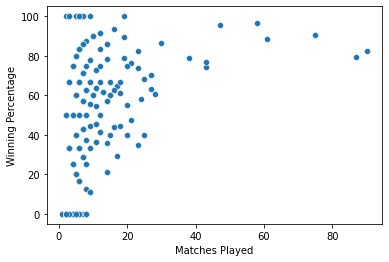

In [529]:
sns.scatterplot(x = df_doubles_grouped['Matches Played'], y = df_doubles_grouped['Winning Percentage'])

plt.savefig('plot.png')

In [530]:
df_doubles_grouped['Matches Played'].sum() / df_doubles_grouped['Matches Played'].count()

5.724223602484472

In [531]:
#df_doubles_grouped['Credit'] = round((df_doubles_grouped['Matches Played'] / df_doubles_grouped['Matches Played'].max()) * df_doubles_grouped['Winning Percentage'] ,2)

df_doubles_grouped['Credit'] = round((df_doubles_grouped['Sets Won']**2) / (df_doubles_grouped['Sets Won'] + df_doubles_grouped['Sets Lost'])    ,2)

In [532]:
df_doubles_grouped.sort_values('Credit', ascending = False).head(13)

,Matches Played,Match Won,Match Lost,Sets Won,Sets Lost,Total Points For,Total Points Against,Set 1 Points For,Set 1 Points Against,Set 2 Points For,...,Number of Final Sets,Winning Percentage,Set Winning Percentage,Set 1 Points For per match average,Set 1 Points Against per match average,Set 2 Points For per match average,Set 2 Points Against per match average,Set 3 Points For per match average,Set 3 Points Against per match average,Credit
Team A,,,,,,,,,,,,,,,,,,,,,
Hugo Rabeux & Julien Grondin,90,74,16,159,41,2232,1318,1018,557,1020,...,20,82.22,79.50,11.31,6.19,11.33,6.19,9.70,10.20,126.40
Adam Blazsovics & Csaba Banyik,75,68,7,141,22,1864,971,862,422,869,...,13,90.67,86.50,11.49,5.63,11.59,5.85,10.23,8.46,121.97
Apor Gyorgydeak & Szabolcs Ilyes,87,69,18,144,43,2049,1227,943,554,975,...,13,79.31,77.01,10.84,6.37,11.21,6.21,10.08,10.23,110.89
Csaba Banyik & Zsanett Janicsek,58,56,2,113,10,1452,835,690,370,682,...,7,96.55,91.87,11.90,6.38,11.76,7.09,11.43,7.71,103.81
Dennis Correia & Luka Pilic,61,54,7,109,17,1419,820,686,357,689,...,4,88.52,86.51,11.25,5.85,11.30,7.03,11.00,8.50,94.29
Bogdan Marojevic & Nikola Mitro,47,45,2,92,11,1202,584,555,236,544,...,9,95.74,89.32,11.81,5.02,11.57,5.89,11.44,7.89,82.17
Maja Umicevic & Nikola Mitro,43,33,10,69,28,1035,766,445,347,473,...,11,76.74,71.13,10.35,8.07,11.00,7.42,10.64,9.09,49.08
Carolyn Greco & Margaret Osmundson,38,30,8,62,18,882,526,417,245,424,...,4,78.95,77.50,10.97,6.45,11.16,6.39,10.25,9.50,48.05
Adrian Duszak & Bartlomiej Franczuk,43,32,11,66,26,972,714,459,322,440,...,6,74.42,71.74,10.67,7.49,10.23,7.65,12.17,10.50,47.35


In [533]:
df_doubles_grouped.sort_values(by= 'Credit', ascending = False).to_excel('credit.xlsx')

MONTH / NUMBER OF WINS PLOT for top 15 set winners

In [580]:
top5_setwinners_list = df_doubles_grouped.sort_values(by= 'Sets Won', ascending = False).iloc[0:5].index.to_list()

In [535]:
df_doubles_concat.matchDateTime

0       2020-02-23T14:00:00
1       2020-02-23T13:00:00
2       2020-02-23T13:00:00
3       2020-02-23T13:00:00
4       2020-02-23T13:00:00
               ...         
4603    2022-03-12T16:10:00
4604    2022-03-12T16:50:00
4605    2022-03-12T16:50:00
4606    2022-03-12T17:30:00
4607    2022-03-12T18:10:00
Name: matchDateTime, Length: 4608, dtype: object

In [536]:
df_doubles_concat.matchDateTime

0       2020-02-23T14:00:00
1       2020-02-23T13:00:00
2       2020-02-23T13:00:00
3       2020-02-23T13:00:00
4       2020-02-23T13:00:00
               ...         
4603    2022-03-12T16:10:00
4604    2022-03-12T16:50:00
4605    2022-03-12T16:50:00
4606    2022-03-12T17:30:00
4607    2022-03-12T18:10:00
Name: matchDateTime, Length: 4608, dtype: object

In [537]:
import datetime

In [538]:
def dateconverter (x):
    return datetime.datetime.strptime(x[0:7], '%Y-%m')
    

In [539]:
dateconverter('2022-02')

datetime.datetime(2022, 2, 1, 0, 0)

In [540]:
df_doubles_concat['Year'] = df_doubles_concat['matchDateTime'].apply(lambda x: dateconverter(x).year)

In [541]:
df_doubles_concat['Month'] = df_doubles_concat['matchDateTime'].apply(lambda x: dateconverter(x).month)

In [542]:
df_doubles_concat.columns

Index(['event_name', 'type', 'playerAName', 'associationPlayer_A',
       'playerBName', 'associationPlayer_B', 'playerXName',
       'associationPlayer_X', 'playerYName', 'associationPlayer_Y', 'stage',
       'matchDateTime', 'setsWon', 'setsLost', 'pointTotal',
       'pointTotalOpponent', 'set1Team', 'set1Opponent', 'set2Team',
       'set2Opponent', 'set3Team', 'set3Opponent', 'Team A', 'Team B',
       'setsCount', 'Match Won', 'Match Lost', 'threeSetMatch', 'Year',
       'Month'],
      dtype='object')

In [543]:
df_doubles_concat.groupby(['Team A','Year', 'Month']).count()['setsWon'][15:25]

Team A                                Year  Month
Achille Wozniak-Lemarie & Alex Nunes  2022  2        2
Adam Bako & Barna Kovacsfi            2021  11       7
                                      2022  2        5
Adam Bako & Lea Vasas                 2021  4        6
                                            7        9
                                            8        6
                                      2022  3        2
Adam Bako & Soma Fordos               2021  5        6
                                            8        6
                                            9        6
Name: setsWon, dtype: int64

In [544]:
## Add the cumulative sum of sets Won per group
df_sum_setsWon = df_doubles_concat.groupby(['Team A','Year', 'Month']).count()['setsWon'].groupby(level=0).cumsum().reset_index()

In [546]:
df_sum_setsWon.head()

,Team A,Year,Month,setsWon
0,Aaly Bekturov & Kutman Ernisov,2021,3,3
1,Abdelkarim Karboudj & Jabar Oumeddour,2021,6,3
2,Abdelmagid Tama & Rida Chaaban,2022,3,3
3,Abdu Abdulghafour & Rasha Kayali,2021,4,3
4,Abdul Rahman Karime & Raed Terkmani,2021,4,5


In [581]:
df_sum_setsWon_top5 = df_sum_setsWon[df_sum_setsWon['Team A'].isin(top5_setwinners_list)].set_index('Team A')

In [582]:
df_sum_setsWon_top5['Date'] = df_sum_setsWon_top5['Year'].astype(str) + "-" + df_sum_setsWon_top5['Month'].astype(str)

In [583]:
df_sum_setsWon_top5.Date.unique()

array(['12-11', '2021-5', '2021-6', '2021-7', '2021-8', '2021-9',
       '2021-10', '2021-11', '2021-12', '2022-1', '2022-2', '2022-3',
       '2020-12', '2021-4'], dtype=object)

In [584]:
df_sum_setsWon_top5 = df_sum_setsWon_top5[df_sum_setsWon_top5.Date != '12-11']

In [ ]:
## PLOTTING

In [586]:
df_sum_setsWon_top5.reset_index(inplace = True)

In [587]:
df_sum_setsWon_top5= df_sum_setsWon_top5.sort_values(['Year','Month'])

<AxesSubplot:xlabel='Date', ylabel='setsWon'>

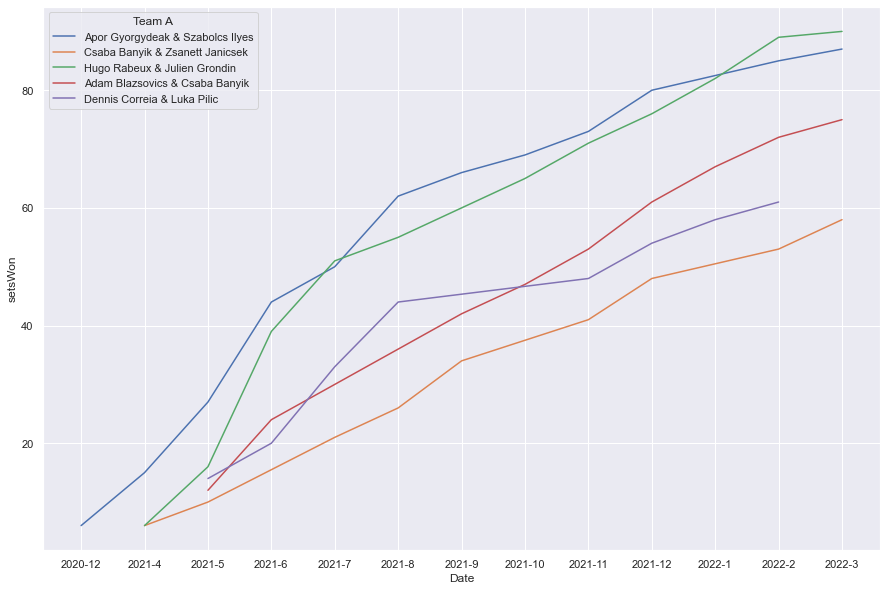

In [588]:
sns.set(rc={'figure.figsize':(15,10)})

sns.lineplot(data=df_sum_setsWon_top5, x="Date", y="setsWon", hue="Team A", markers= True)





In [ ]:
## CREATE SINGLES DATABASE

In [ ]:
df1['type'].unique()
df1_singles = df1[df1['type'].isin(['SinglesFree','SinglesMen', 'SinglesWomen'])]

In [ ]:
df1_singles.shape

(4569, 22)

In [ ]:
df1_singles.columns

Index(['event_name', 'type', 'playerAName', 'associationPlayer_A',
       'playerBName', 'associationPlayer_B', 'playerXName',
       'associationPlayer_X', 'playerYName', 'associationPlayer_Y', 'stage',
       'matchDateTime', 'setsWon_A', 'setsWon_X', 'pointTotal_A',
       'pointTotal_X', 'set1_AB', 'set1_XY', 'set2_AB', 'set2_XY', 'set3_AB',
       'set3_XY'],
      dtype='object')

In [ ]:
df1_singles_A = df1_singles.rename(columns = {'playerAName': 'player', 'associationPlayer_A': 'nationality',
       'playerXName': 'opponent',
       'associationPlayer_X':'opponent_nationality', 'setsWon_A': 'setsWonPlayer', 'setsWon_X':'setsLostPlayer', 'pointTotal_A':'pointTotalPlayer',
       'pointTotal_X':'pointTotalOpponent', 'set1_AB':'set1Player', 'set1_XY':'set1Opponent', 'set2_AB':'set2Player', 'set2_XY': 'set2Opponent', 'set3_AB': 'set3Player',
       'set3_XY': 'set3Opponent'})

df1_singles_B = df1_singles.rename(columns = {'playerAName': 'opponent', 'associationPlayer_A': 'opponent_nationality',
       'playerXName': 'player',
       'associationPlayer_X':'nationality', 'setsWon_A': 'setsLostPlayer', 'setsWon_X':'setsWonPlayer', 'pointTotal_A':'pointTotalOpponent',
       'pointTotal_X':'pointTotalPlayer', 'set1_AB':'set1Opponent', 'set1_XY':'set1Player', 'set2_AB':'set2Opponent', 'set2_XY': 'set2Player', 'set3_AB': 'set3Opponent',
       'set3_XY': 'set3Player'})





In [ ]:
df_singles = df1_singles_A.append(df1_singles_B)

<ipython-input-187-9e59ad5d6ebc>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_singles = df1_singles_A.append(df1_singles_B)


In [ ]:
df_singles.shape

(9138, 22)

In [ ]:
df_singles[['set3Player', 'set3Opponent']] = df_singles[['set3Player', 'set3Opponent']].mask((df_singles["set3Player"] == 0) &(df_singles['set3Opponent'] == 0), np.nan)

In [ ]:
df_singles['setsplayed'] = df_singles['setsWonPlayer'] + df_singles['setsLostPlayer']

In [ ]:
df_singles['set2Player'].replace(21,12, inplace = True)

In [ ]:
df_singles[df_singles['player'] == 'Ibrahim Kamara']



,event_name,type,player,nationality,playerBName,associationPlayer_B,opponent,opponent_nationality,playerYName,associationPlayer_Y,...,setsLostPlayer,pointTotalPlayer,pointTotalOpponent,set1Player,set1Opponent,set2Player,set2Opponent,set3Player,set3Opponent,setsplayed
2231,Sierra Leone Challenger Series - Round 1,SinglesFree,Ibrahim Kamara,Sierra Leone,,,Ansumana Kanneh,Sierra Leone,,,...,0,24,7,12,3,12,4,NaN,NaN,2
2234,Sierra Leone Challenger Series - Round 1,SinglesFree,Ibrahim Kamara,Sierra Leone,,,Amza Bangura,Sierra Leone,,,...,0,33,7,12,3,12,4,NaN,NaN,2
2235,Sierra Leone Challenger Series - Round 1,SinglesFree,Ibrahim Kamara,Sierra Leone,,,Ibrahim Sesay,Sierra Leone,,,...,0,24,11,12,7,12,4,NaN,NaN,2
2245,Sierra Leone Challenger Series - Round 1,SinglesFree,Ibrahim Kamara,Sierra Leone,,,Abdulai Bangura,Sierra Leone,,,...,0,24,12,12,3,12,9,NaN,NaN,2
2285,Sierra Leone Challenger Series - Round 2,SinglesFree,Ibrahim Kamara,Sierra Leone,,,Samuel Conteh,Sierra Leone,,,...,0,24,18,12,11,12,7,NaN,NaN,2
2288,Sierra Leone Challenger Series - Round 2,SinglesFree,Ibrahim Kamara,Sierra Leone,,,Kadiatu G Kamara,Sierra Leone,,,...,0,24,5,12,2,12,3,NaN,NaN,2
2293,Sierra Leone Challenger Series - Round 2,SinglesFree,Ibrahim Kamara,Sierra Leone,,,Lamranah Bangura,Sierra Leone,,,...,0,24,3,12,2,12,1,NaN,NaN,2
2267,Sierra Leone Challenger Series - Round 1,SinglesFree,Ibrahim Kamara,Sierra Leone,,,Musa Sannoh,Sierra Leone,,,...,0,24,10,12,6,12,4,NaN,NaN,2
2268,Sierra Leone Challenger Series - Round 1,SinglesFree,Ibrahim Kamara,Sierra Leone,,,Abdulai Bangura,Sierra Leone,,,...,0,24,13,12,4,12,9,NaN,NaN,2
2286,Sierra Leone Challenger Series - Round 2,SinglesFree,Ibrahim Kamara,Sierra Leone,,,Issa Kargbo,Sierra Leone,,,...,0,24,9,12,4,12,5,NaN,NaN,2


In [ ]:
df_singles_grouped = df_singles.groupby(['player', 'nationality']).agg({
    'opponent': 'count',
    'setsWonPlayer': 'mean',
    'setsLostPlayer': 'mean',
    'pointTotalPlayer': 'sum',
    'pointTotalOpponent': 'mean',
    'set1Player': 'mean',
    'set1Opponent': 'mean',
    'set2Player': 'mean',
    'set2Opponent': 'mean',
    'set3Player': 'mean',
    'set3Opponent': 'mean',
    'setsplayed': 'sum'
})

In [ ]:
df_singles_grouped

,,opponent,setsWonPlayer,setsLostPlayer,pointTotalPlayer,pointTotalOpponent,set1Player,set1Opponent,set2Player,set2Opponent,set3Player,set3Opponent,setsplayed
player,nationality,,,,,,,,,,,,
A Hari Prakash B Ananda Kumar,India,7,1.142857,0.857143,135,18.714286,9.714286,9.285714,9.571429,9.428571,NaN,NaN,14
Aakash Ramachandhiran,India,4,0.250000,2.000000,43,26.250000,4.250000,12.000000,5.000000,11.250000,6.000000,12.000000,9
Abburi Venkata Sai Kiran Abburi Venkatesh,India,8,1.500000,0.750000,190,20.125000,9.750000,9.750000,11.000000,8.875000,12.000000,6.000000,18
Abdelwaly Ferhat,United States,1,0.000000,2.000000,4,24.000000,1.000000,12.000000,3.000000,12.000000,NaN,NaN,2
Abdillahi Mohamed Hassan,Djibouti,10,0.600000,1.400000,150,20.400000,7.800000,10.000000,7.200000,10.400000,NaN,NaN,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zsanett Janicsek,Hungary,45,1.133333,1.022222,898,18.066667,9.244444,8.000000,9.244444,8.688889,9.428571,8.857143,97
Zsofia Dezsenyi,Hungary,9,0.111111,2.000000,97,25.222222,5.555556,11.888889,4.333333,12.000000,8.000000,12.000000,19
Zsolt Lazar,Romania,25,1.600000,0.640000,618,17.400000,11.200000,7.560000,11.000000,7.760000,10.500000,8.666667,56


In [ ]:
df_singles_grouped['pointPerSet'] = df_singles_grouped['pointTotalPlayer'] / df_singles_grouped['setsplayed']

In [ ]:
df_singles_grouped.sort_values('pointPerSet', ascending = False)['pointPerSet']

player                         nationality  
Ibrahim Kamara                 Sierra Leone     12.136364
Dillion Emeka Nwachukwu        Niger            12.000000
Lino Blute                     Guinea-Bissau    11.900000
Taribo Bhembe                  Eswatini         11.886364
Gamara Da Silva                Guinea-Bissau    11.885714
                                                  ...    
Sali Shenol Sadakov            Bulgaria          1.250000
Mohammad Naser Albaghli        Kuwait            0.800000
Sulaiman Sadeq Hussain Alimir  Kuwait            0.333333
Harison Danny  Tongasoa        Madagascar        0.000000
Aliu Balde                     Guinea-Bissau     0.000000
Name: pointPerSet, Length: 964, dtype: float64

In [ ]:
## group by Player A

In [ ]:
singles_mean = df1_singles.groupby('playerAName').agg({'setsWon_A': 'mean', 'setsWon_X': 'mean' ,'pointTotal_A': 'mean', 'pointTotal_X': 'mean', 'set1_AB': 'mean', 'set1_XY': 'mean', 'set2_AB': 'mean', 'set2_XY': 'mean', 'set3_AB': 'mean', 'set3_XY': 'mean' }, ).astype(int)

In [ ]:
singles_mean.sort_values(by="pointTotal_A", ascending = False)

,setsWon_A,setsWon_X,pointTotal_A,pointTotal_X,set1_AB,set1_XY,set2_AB,set2_XY,set3_AB,set3_XY
playerAName,,,,,,,,,,
Umar Muaz,2,1,38,35,12,8,9,12,17,15
Mario Antonio Carvalho Alves,2,1,38,35,12,10,11,12,15,13
Raja A Sam Rithick Arokiadass,2,1,36,32,12,6,8,12,16,14
Islam Sleiman,2,1,36,31,12,8,11,12,13,11
Martin Yordanov,2,1,35,33,12,11,11,12,12,10
...,...,...,...,...,...,...,...,...,...,...
Abdou Aziz Badji,0,2,4,24,3,12,1,12,0,0
Setranambinina Jaoba Ramanitrarivo,0,2,3,24,1,12,2,12,0,0
Sali Shenol Sadakov,0,2,3,24,1,12,1,12,0,0
